In [262]:
# Import the needed packages

import os
import copy
import warnings
import logging
import numpy as np
import healpy as hp
import skyproj
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, HTML

from astropy.coordinates import SkyCoord, Angle
from astropy.time import Time, TimeDelta
import astropy.units as u
import astropy
astropy.utils.iers.conf.iers_degraded_accuracy = 'ignore'

from zoneinfo import ZoneInfo

timezone = "Chile/Continental"
tz = ZoneInfo(timezone)
tz_utc = ZoneInfo("UTC")

# For making airmass plots, if desired
from astroplan import FixedTarget, Observer
from astroplan.plots import plot_airmass

from rubin_scheduler.scheduler.utils import generate_all_sky, Footprint

from rubin_scheduler.scheduler import sim_runner
from rubin_scheduler.site_models import Almanac
from rubin_scheduler.utils import Site, angular_separation

from rubin_scheduler.scheduler.model_observatory import ModelObservatory, KinemModel
from rubin_scheduler.scheduler.schedulers import SimpleBandSched, CoreScheduler
import rubin_scheduler.scheduler.example as ex
from rubin_scheduler.scheduler.surveys import FieldSurvey
import rubin_scheduler.scheduler.basis_functions as basis_functions
import rubin_scheduler.scheduler.detailers as detailers

from rubin_scheduler.scheduler.utils import SchemaConverter
import rubin_sim.maf.plots as plots
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.metric_bundles as mb

# If running on the USDF, find rubin_scheduler data here:
if "usdf" in os.getenv("EXTERNAL_INSTANCE_URL", ""):
    os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/data/rubin/shared/rubin_sim_data"

In [14]:
# When might we start and end the survey?
# What would the actual time on-sky look like? 
# (start on dayobs rollover, so T12:00:00)
survey_start = Time('2025-06-11T12:00:00', format='isot', scale='utc')
survey_end = Time('2025-08-30T12:00:00', format='isot', scale='utc')
survey_length = int(np.ceil((survey_end - survey_start).jd))

nside = 32

print(survey_start.iso, survey_end.isot, survey_length)

site = Site("LSST")
almanac = Almanac(mjd_start=survey_start.mjd)
match = np.where(
    (almanac.sunsets["night"] >= 0) & (almanac.sunsets["night"] <= survey_length)
)
sunsets = almanac.sunsets[match]["sun_n18_setting"]
sunrises = almanac.sunsets[match]["sun_n18_rising"]

print(Time(sunsets[0], format='mjd', scale='utc').iso, 
      Time(sunrises[0], format='mjd', scale='utc').iso, 
      Time(sunsets[-1], format='mjd', scale='utc').iso, 
      Time(sunrises[-1], format='mjd', scale='utc').iso)

sun_ra_start = almanac.get_sun_moon_positions(survey_start.mjd,)["sun_RA"][0]
print(sun_ra_start)

2025-06-11 12:00:00.000 2025-08-30T12:00:00.000 80
2025-06-10 23:14:51.415 2025-06-11 10:10:30.431 2025-08-29 23:46:22.102 2025-08-30 09:40:37.585
1.3897159617309942


Text(0.5, 1.0, 'SV surveys from 2025-06-11 to 2025-08-30')

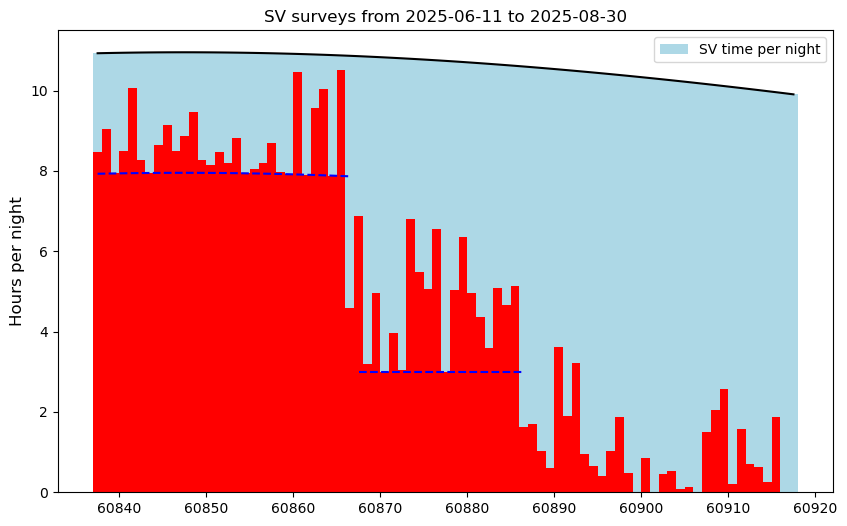

In [373]:
# Set up an approximation for downtime, including masking time used for other engineering

# Let's assume for the first 30 days only the last 3 hours of the night are available
step1 = 30
down_starts = sunsets[0:step1]
down_ends = sunrises[0:step1] - 3.0 / 24
step2 = 50
down_starts = np.concatenate([down_starts, sunsets[step1:step2]])
down_ends = np.concatenate([down_ends, sunsets[step1:step2] + 3.0 / 24])
# And then from July through end of August, gets all of the night - don't have to specify
# but for random downtime below, will do so anyway
down_starts = np.concatenate([down_starts, sunsets[step2:]])
down_ends = np.concatenate([down_ends, sunsets[step2:]])

# But let's add random periods of downtime within each night
rng = np.random.default_rng(seed=55)
# Assume some chance of having some amount of downtime
# (but this is simplistic and assumes downtime once per night
threshold = .7
prob_down = rng.random(len(sunsets))
time_down = rng.gumbel(loc=0.5, scale=1, size=len(sunsets)) # in hours
hours_in_night = (sunrises - sunsets) * 24
avail_in_night = (sunrises - sunsets) * 24 - (down_ends - down_starts) * 24
time_down = np.where(time_down >= avail_in_night, avail_in_night - 0.1, time_down) 
time_down = np.where(time_down <= 0, 0, time_down)

latest_start = avail_in_night - time_down
d_starts = rng.uniform(low=down_ends, high=down_ends + latest_start / 24.0)
d_ends = d_starts + time_down / 24.0

# combine
down_starts = np.concatenate([down_starts, d_starts])
down_ends = np.concatenate([down_ends, d_ends])

# Can make an array of downtimes - 
# down_starts/ down_ends should be mjd times for internal-ModelObservatory use
downtimes = np.array(
                list(zip(down_starts, down_ends)),
                dtype=list(zip(["start", "end"], [float, float])),
            )
downtimes.sort(order="start")

dayobsmjd = np.arange(survey_start.mjd, survey_start.mjd + survey_length+0.5, 1)
downtime_per_night = np.zeros(len(sunrises))
for start, end in zip(downtimes['start'], downtimes['end']):
    idx = np.where((start > dayobsmjd) & (end < dayobsmjd+1))
    downtime_per_night[idx] += (end - start) * 24

plt.figure(figsize=(10,6))
plt.plot(dayobsmjd, available_time_per_night, 'k')
w = 1
plt.bar(dayobsmjd, downtime_per_night, width=w, color='r')
plt.bar(dayobsmjd, available_time_per_night - downtime_per_night, bottom=downtime_per_night, width=w,
        color='lightblue', label="SV time per night")
plt.plot(dayobsmjd[0:step1], available_time_per_night[0:step1] - 3, 'b--')
plt.plot(dayobsmjd[step1:step2], np.ones(step2-step1) * 3, 'b--')
plt.legend()
plt.ylabel("Hours per night", fontsize='large')
plt.title(f"SV surveys from {survey_start.iso[0:10]} to {survey_end.iso[0:10]}")

lst midnight @ start 259.70347088224753 lst midnight @ mid 300.8018104810795 lst midnight @ end 338.7599185166972
lst sunset @ mid 220.0506275914175 lst sunrise @ mid 21.55299339233505
south area 1175.0111032956336 south approx n fields 159.11608690461708
north area 651.2918686838655 south approx n fields 88.19577388427346
total area 1826.302971979499 total approx n fields 247.31186078889056
approx blob fields 99.0
closest approach to ecliptic in south area (deg)? -53.97543841632944
max/min elevation in south? 9.983784728061089 28.675375352803158
max/min elevation in north? 25.46420815280084 35.02459184719916
DDF radius 5.641895835477563 DD area, not including dither edges 100.71523742534 very approximate n fields 151.07285613801002
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


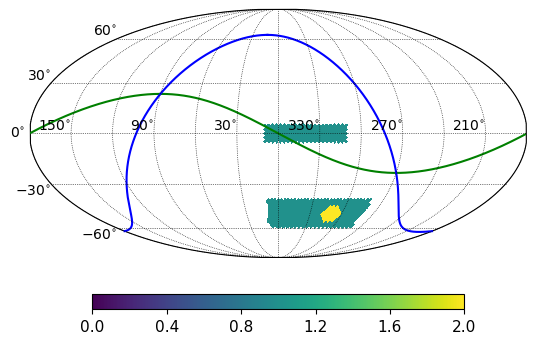

In [253]:
# Need to define the footprint (let's start with the wide area footprint)

sky = generate_all_sky(nside=nside)

# middle of the night in the middle of the survey
loc = site.to_earth_location()
idx = int(survey_length / 2)
mid_survey = Time(sunsets[idx] + (sunrises[idx] - sunsets[idx])/2, format='mjd', scale='utc', location=loc)
mid_lst = mid_survey.sidereal_time('mean')
idx = 0
start_lst = Time(sunsets[idx] + (sunrises[idx] - sunsets[idx])/2, format='mjd', scale='utc', location=loc).sidereal_time('mean')
idx = -1
end_lst = Time(sunsets[idx] + (sunrises[idx] - sunsets[idx])/2, format='mjd', scale='utc', location=loc).sidereal_time('mean')

print('lst midnight @ start', start_lst.deg, 'lst midnight @ mid', mid_lst.deg, 'lst midnight @ end', end_lst.deg)
idx = int(survey_length / 2)
sunset_mid_lst = Time(sunsets[idx], format='mjd', scale='utc', location=loc).sidereal_time('mean')
sunrise_mid_lst = Time(sunrises[idx], format='mjd', scale='utc', location=loc).sidereal_time('mean')
print('lst sunset @ mid', sunset_mid_lst.deg, 'lst sunrise @ mid', sunrise_mid_lst.deg)

# Keith's suggested areas - two regions .. 
south = np.where((((sky['ra'] > 280) & (sky['ra'] <= 360)) | ((sky['ra'] >= 0) & (sky['ra'] < 10))) 
                 & (sky['dec'] < -40) & (sky['dec'] > -60))
north = np.where((((sky['ra'] > 310) & (sky['ra'] <= 360)) | ((sky['ra'] >= 0) & (sky['ra'] < 10))) 
                 & (sky['dec'] < 5) & (sky['dec'] > -5))

sky['map'] = np.zeros(hp.nside2npix(nside)) + np.nan
sky['map'][south] = 1
sky['map'][north] = 1

# Check individually, relevant for blob coverage.. 
area_south = len(np.where(sky['map'][south] == 1)[0]) * hp.nside2pixarea(nside, degrees=True)
approx_nfields_south = area_south / 9.6 * 1.3
print('south area', area_south, 'south approx n fields', approx_nfields_south)
area_north = len(np.where(sky['map'][north] == 1)[0]) * hp.nside2pixarea(nside, degrees=True)
approx_nfields_north = area_north / 9.6 * 1.3
print('north area', area_north, 'south approx n fields', approx_nfields_north)
# And together
print('total area', area_south + area_north, 'total approx n fields', approx_nfields_south + approx_nfields_north)

# How many fields are typically in a 'blob' with pair time of 33 minutes?
print('approx blob fields',  33 * 2 * 60 / (32+8))
# so .. looks like we'd cover the north and then south in a single blob of pairs each?
      

print('closest approach to ecliptic in south area (deg)?', sky['eclip_lat'][south].min())
print('max/min elevation in south?', abs(sky['dec'][south].max() - site.latitude), abs(sky['dec'][south].min() - site.latitude))
print('max/min elevation in north?', abs(site.latitude - sky['dec'][north].min()), abs(site.latitude - sky['dec'][north].max()))

dd_ra = 310
dd_dec = -50
radius = np.sqrt(100 / np.pi)
dist = angular_separation(dd_ra, dd_dec, sky['ra'], sky['dec'])
close = np.where(dist <= radius)[0]
dd = np.zeros(hp.nside2npix(nside)) + np.nan
dd[close] = 1

area_dd = len(np.where(dd == 1)[0]) * hp.nside2pixarea(nside, degrees=True)
approx_nfields_dd = area_dd * 1.5
print("DDF radius", radius, "DD area, not including dither edges", area_dd, "very approximate n fields", approx_nfields_dd)

temp = np.where(np.isnan(sky['map']), 0, sky['map']) +  np.where(np.isnan(dd), 0, 2*dd)
temp[np.where(temp == 0)] = np.nan
temp = np.ma.MaskedArray(temp)
s = slicers.HealpixSlicer(nside=nside)
p = plots.HpxmapPlotter()
fig = p(temp, s, {'color_max': 2, 'color_min': 0, 'n_ticks': 5})

In [362]:
# Turn this into a Footprint to use with the scheduler - 
# low-dust-ratios
lowdust_band_ratios = {"u": 0.35, "g": 0.4, "r": 1.0, "i": 1.0, "z": 0.9, "y": 0.9}
dd_footprints_hp = np.zeros(hp.nside2npix(nside), 
                         dtype=list(zip(["u", "g", "r", "i", "z", "y"], [float] * 7)),)
for b in 'ugrizy':
    dd_footprints_hp[b] = dd * lowdust_band_ratios[b]

dd_goals = [round(lowdust_band_ratios[k] * 184) for k in lowdust_band_ratios]
print(dd_goals, np.array(dd_goals)/30, np.array(dd_goals).sum()/30)
# This would likely be the necessary visits per night that are required? But sim fails.
seq = {'u': 16, 'g': 4, 'r': 12, 'i': 12, 'z': 12, 'y': 31}
tt = [round(seq[k] * 1.0) for k in seq]
print((np.array(tt) * (32 + 5)).sum()/60)
# Try shorter seq
seq = {'u': 9, 'g': 2, 'r': 6, 'i': 6, 'z': 6, 'y': 15}
tt = [round(seq[k] * 1.0) for k in seq]
print((np.array(tt) * (32 + 5)).sum()/60)
       
# flat for SV 
band_ratios = {"u": 0, "g": 1.0, "r": 1.0, "i": 1.0, "z": 1.0, "y": 0}

footprint = Footprint(mjd_start = survey_start.mjd, 
                      sun_ra_start = sun_ra_start)                     
for b in 'ugrizy':
    footprint.set_footprint(bandname=b, values=sky['map'] * band_ratios[b])

# But maybe we want to use just the healpix in a dict .. 
footprints_hp = np.zeros(hp.nside2npix(nside), 
                         dtype=list(zip(["u", "g", "r", "i", "z", "y"], [float] * 7)),)
for b in 'ugrizy':
    footprints_hp[b] = sky['map'] * band_ratios[b]

[64, 74, 184, 184, 166, 166] [2.13333333 2.46666667 6.13333333 6.13333333 5.53333333 5.53333333] 27.933333333333334
53.65
27.133333333333333


In [363]:
# Pull up a pretty standard set of masks and a simple pair survey

standard_masks = ex.standard_masks(nside=nside, moon_distance=30, wind_speed_maximum=40)

camera_rot_limits = [-80, 80]

# And set up some simple pairs surveys .. probably will need modification
# (also this is slow because the simple_pairs_survey is redoing some of the work already done above ..hmm)
standard_pairs = [['u', 'g'], ['u', 'r'], ['g', 'r'], ['r', 'i'], ['i', 'z'], ['z', 'y'], ['y', 'y']]
sv_pairs = [['g', 'r'], ['r', 'i'], ['i', 'z'], ['g', 'z']]
pair_surveys = {}
for b1, b2 in sv_pairs:
    pair_surveys[f"{b1}{b2}"] = ex.simple_pairs_survey(nside=nside, bandname=b1, bandname2=b2, 
                                                 mask_basis_functions=standard_masks,
                                                 reward_basis_functions=None,
                                                 reward_basis_functions_weights=None,
                                                 footprints_hp=footprints_hp,
                                                 survey_start=survey_start.mjd,
                                                 camera_rot_limits=camera_rot_limits,
                                                 pair_time=33, 
                                                 exptime=30, 
                                                 nexp=1, 
                                                 science_program='BLOCK-P')

# We'll probably need greedy surveys to fill short periods of time
greedy_surveys = {}
for b in 'griz':
    greedy_surveys[b] = ex.simple_greedy_survey(nside=nside, 
                                                bandname=b,
                                                mask_basis_functions=standard_masks,
                                                reward_basis_functions=None,
                                                reward_basis_functions_weights=None,
                                                survey_start=survey_start.mjd, 
                                                footprints_hp=footprints_hp,
                                                camera_rot_limits=camera_rot_limits,
                                                exptime=30,
                                                nexp=1,
                                                science_program='BLOCK-G')

# And the DDF survey .. have to think about this. 
# ToO Scripted Survey might be best, but would have to adapt trigger.
# A FieldSurvey provides sequences, could modify detailer to handle dithering as needed.
dd_survey_note = "DD: lsstcam commissioning"
dd_masks = ex.standard_masks(nside=nside, moon_distance=30, wind_speed_maximum=40, shadow_minutes=45)
bfs = dd_masks + [basis_functions.VisitGap(note=dd_survey_note, gap_min=600),
                        basis_functions.SlewtimeBasisFunction(bandname=None, nside=nside),
                        basis_functions.M5DiffBasisFunction(bandname="r", fiducial_FWHMEff=0.7, nside=nside)]
detailer_list = []
# Avoid camera rotator limits.
detailer_list.append(
    detailers.CameraRotDetailer(min_rot=np.min(camera_rot_limits), max_rot=np.max(camera_rot_limits))
)
# Convert rotTelPos to rotSkyPos_desired
detailer_list.append(detailers.Rottep2RotspDesiredDetailer(telescope="rubin"))
# Sets a flush-by date to avoid running into prescheduled visits.
detailer_list.append(detailers.FlushForSchedDetailer())
detailer_list.append(detailers.DitherDetailer(per_night=False, max_dither=radius))

dd_survey = FieldSurvey(basis_functions=bfs,
                        RA=dd_ra,
                        dec=dd_dec,
                        sequence='ugrizy',
                        nvisits={'u': 9, 'g': 2, 'r': 6, 'i': 6, 'z': 6, 'y': 15},
                        exptimes=30, 
                        nexps=1,
                        ignore_obs=None,
                        survey_name="DD Lsstcam Commissioning",
                        scheduler_note=dd_survey_note,
                        science_program="BLOCK-D",
                        nside=nside, 
                        flush_pad=30,
                        detailers=detailer_list)

# dd_surveys = {}
# for b in 'ugrizy':
#     dd_surveys[b] = ex.simple_greedy_survey(nside=nside, 
#                                             bandname=b,
#                                             mask_basis_functions = standard_masks,
#                                             reward_basis_functions = None,
#                                             reward_basis_functions_weights = None,
#                                             survey_start = survey_start.mjd, 
#                                             footprints_hp = dd_footprints_hp,
#                                             camera_rot_limits = [-80, 80],
#                                             exptime = 30,
#                                             nexp = 25,
#                                             science_program = 'BLOCK-D')
#     dd_surveys[b].scheduler_note = f"DD greedy survey {b}"

In [364]:
survey_lists = [[copy.deepcopy(dd_survey)], [copy.deepcopy(pair_surveys[k]) for k in pair_surveys], [copy.deepcopy(greedy_surveys[k]) for k in greedy_surveys]]

logger = logging.getLogger()

scheduler = CoreScheduler(survey_lists, nside, log=logger, camera='LSST', telescope='rubin', band_to_filter={'u': 'u', 'g': 'g', 'r': 'r', 'i': 'i', 'z': 'z', 'y': 'y'})
scheduler.survey_lists

[[<FieldSurvey survey_name='DD Lsstcam Commissioning', RA=5.410520681182422, dec=-0.8726646259971648 at 0x184634f50>],
 [<BlobSurvey survey_name='simple pair 33, gr' at 0x184637d90>,
  <BlobSurvey survey_name='simple pair 33, ri' at 0x184637ed0>,
  <BlobSurvey survey_name='simple pair 33, iz' at 0x184636990>,
  <BlobSurvey survey_name='simple pair 33, gz' at 0x184636fd0>],
 [<GreedySurvey survey_name='simple greedy g' at 0x184636e90>,
  <GreedySurvey survey_name='simple greedy r' at 0x184636d50>,
  <GreedySurvey survey_name='simple greedy i' at 0x184636c10>,
  <GreedySurvey survey_name='simple greedy z' at 0x184636ad0>]]

In [365]:
# What does the observatory look like?  (remember to set this back up if you change the downtimes)
setup_observatory = False 
if setup_observatory:
    model_obs = ModelObservatory(nside=nside, 
                                   mjd=survey_start.mjd, 
                                   mjd_start=survey_start.mjd, 
                                   cloud_data="ideal", # noclouds
                                   seeing_data=None, # standard seeing, but could modify
                                   wind_data=None,
                                   downtimes = downtimes)
    # Slow the telescope down with smaller jerk/acceleration, and smaller maxvel
    # But is faster with settle of 0 (Tiago is working on this)
    model_obs.setup_telescope(
        altitude_maxspeed=2.0,
        altitude_accel=2.0,
        altitude_jerk=8.0,
        azimuth_maxspeed=2.0,
        azimuth_accel=2.0,
        azimuth_jerk=8.0,
        settle_time=0.0,
    )

observatory = copy.deepcopy(model_obs)

# Filter scheduler - simply changes between ugriz and grizy depending on lunar phase
fs = SimpleBandSched(illum_limit=40)

In [366]:
%%capture sched_log
# Catch the RuntimeWarning if calc_reward returns all nans or if we're in downtime
rewards = True
scheduler.keep_rewards=rewards

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    vals = sim_runner(
        observatory,
        scheduler,
        band_scheduler=fs,
        sim_start_mjd=survey_start.mjd,
        sim_duration=survey_length,
        record_rewards=rewards,
        verbose=True,
    )
observatory = vals[0]
scheduler = vals[1]
observations = vals[2]
if len(vals) == 5:
    rewards = vals[3]
    obs_rewards = vals[4]

In [370]:
tt

[9, 2, 6, 6, 6, 15]

In [359]:
#sched_log.stderr

Text(0.5, 1.0, 'SV surveys from 2025-06-11 to 2025-08-30')

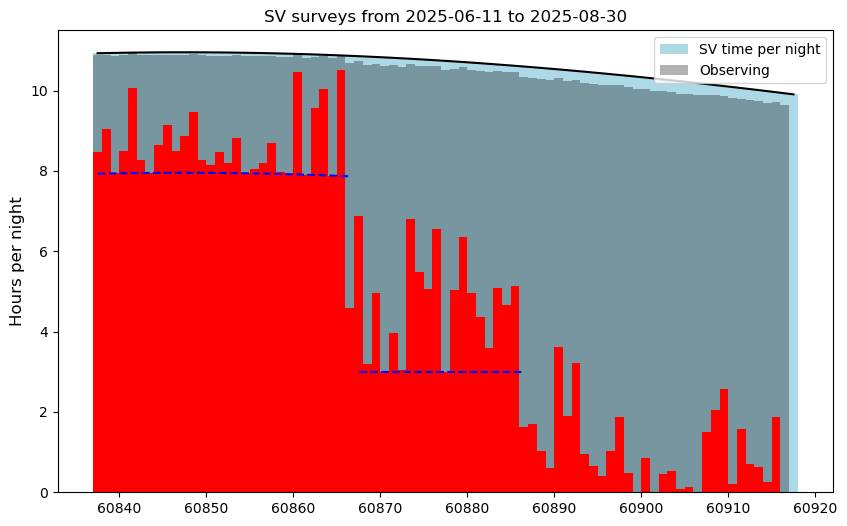

In [402]:
# Did we manage to schedule the available time? 

plt.figure(figsize=(10,6))
plt.plot(dayobsmjd, available_time_per_night, 'k')
w = 1
plt.bar(dayobsmjd, downtime_per_night, width=w, color='r')
plt.bar(dayobsmjd, available_time_per_night - downtime_per_night, bottom=downtime_per_night, width=w,
        color='lightblue', label="SV time per night")
plt.plot(dayobsmjd[0:step1], available_time_per_night[0:step1] - 3, 'b--')
plt.plot(dayobsmjd[step1:step2], np.ones(step2-step1) * 3, 'b--')

night = np.searchsorted(night_starts, observations['mjd'], side='left') - 1
obs_time = np.zeros(len(sunrises))
for i in range(len(sunrises)):
    idx = np.where((observations['mjd'] > sunsets[i]) & (observations['mjd'] < sunrises[i]))[0]
    obs_time[i-1] = (observations['exptime'][idx] + observations['slewtime'][idx]).sum() / 60 / 60

plt.bar(dayobsmjd, obs_time,  bottom=downtime_per_night, color='k', width=w, alpha=0.3, label='Observing')

plt.legend()
plt.ylabel("Hours per night", fontsize='large')
plt.title(f"SV surveys from {survey_start.iso[0:10]} to {survey_end.iso[0:10]}")

In [375]:
visits = SchemaConverter().obs2opsim(observations)
visitsdf = pd.DataFrame(visits)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


{'SkyMap': <Figure size 640x480 with 2 Axes>,
 'Histogram': <Figure size 640x480 with 1 Axes>}

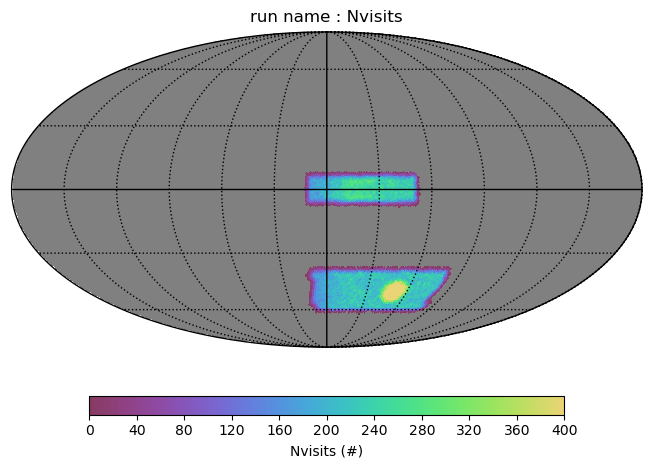

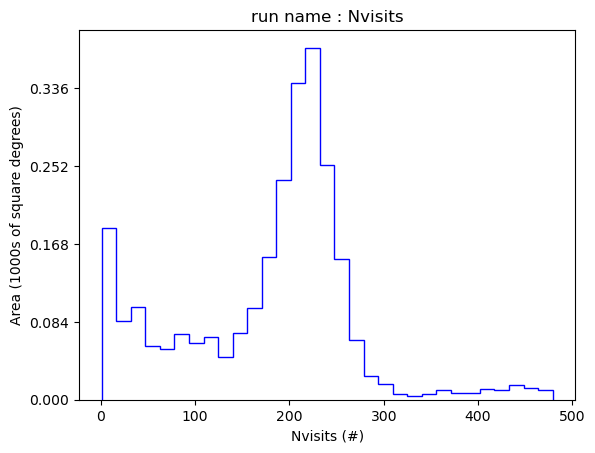

In [376]:
m = metrics.CountMetric('observationStartMJD', metric_name='Nvisits')
s = slicers.HealpixSlicer(64)
constraint = ''
plot_dict = {'color_min': 0, 'color_max': 400}
bundle = mb.MetricBundle(m, s, constraint, plot_dict=plot_dict)
g = mb.MetricBundleGroup({0: bundle}, None)
g.run_current(constraint, sim_data=visitsdf.to_records())
bundle.plot()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
g max nvisits 83.0 median 49.0
r max nvisits 112.0 median 49.0
i max nvisits 114.0 median 53.0
z max nvisits 122.0 median 51.0


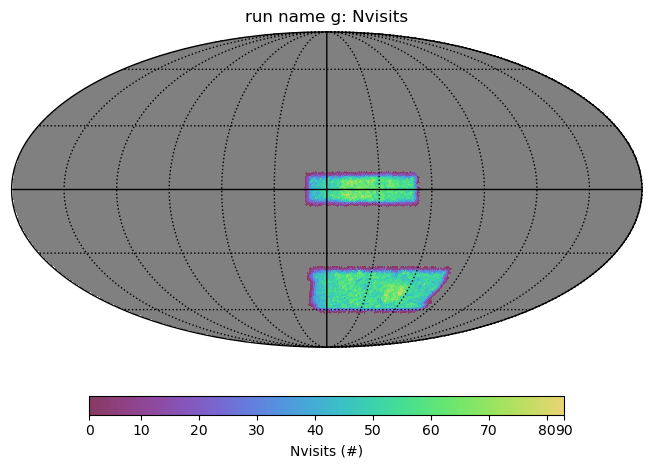

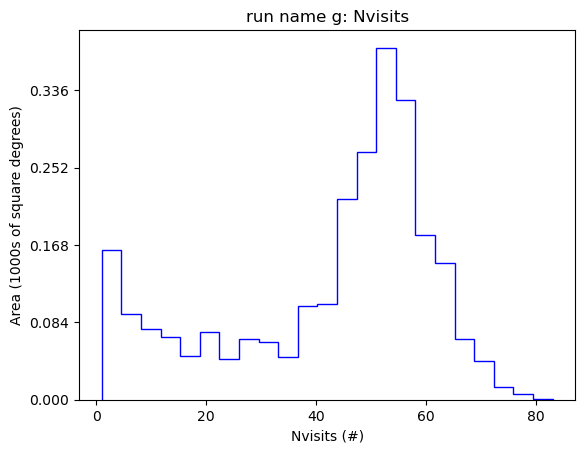

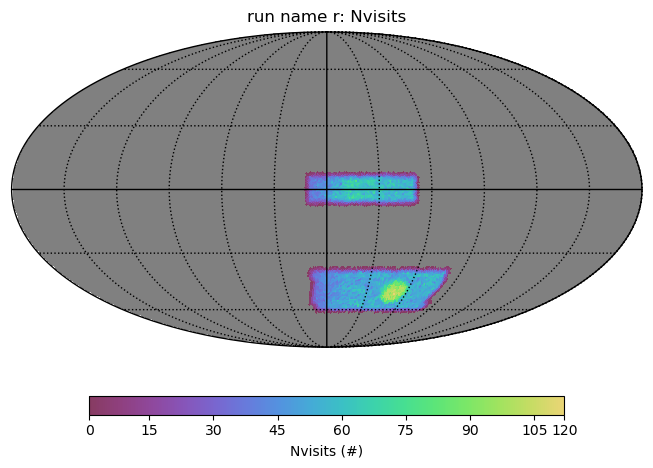

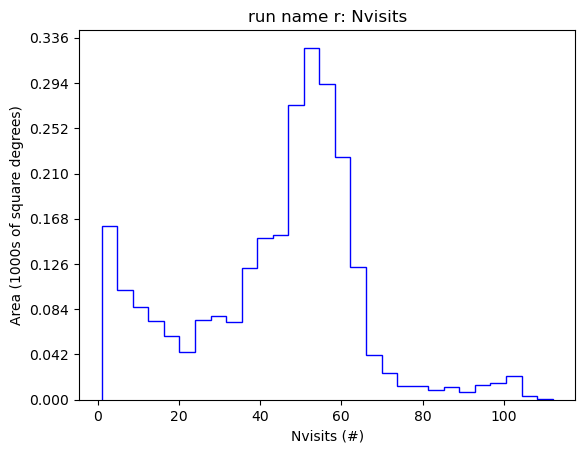

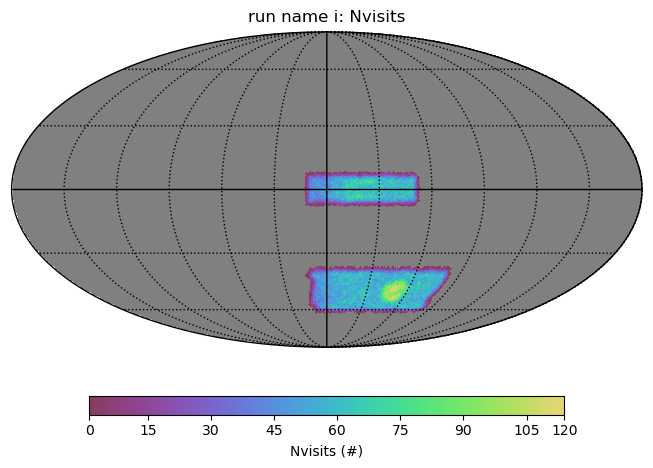

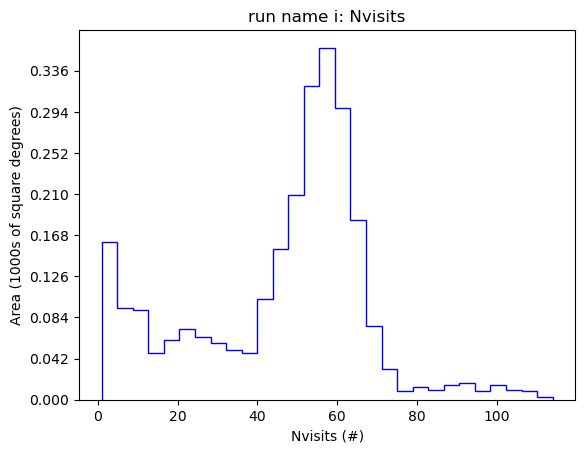

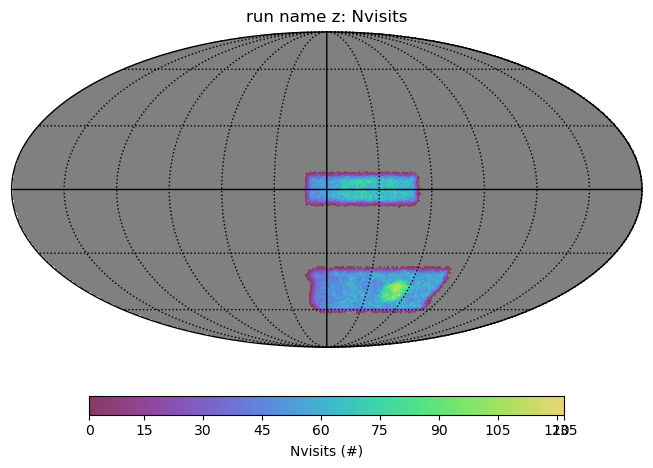

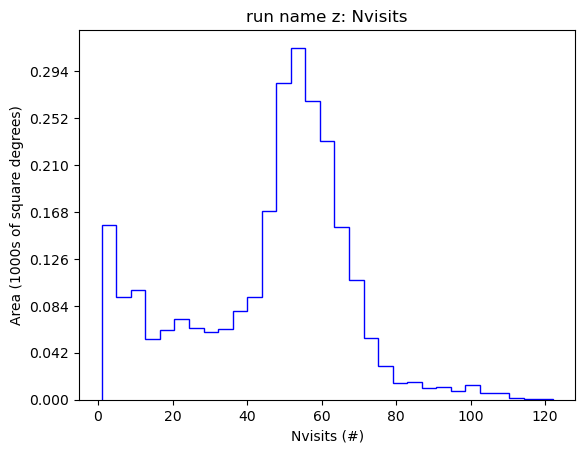

In [400]:
bundles = {}
m = metrics.CountMetric('observationStartMJD', metric_name='Nvisits')
s = slicers.HealpixSlicer(64)
for i, b in enumerate('griz'):
    constraint = b
    bundles[b] = mb.MetricBundle(m, s, constraint)
    g = mb.MetricBundleGroup({0: bundles[b]}, None)
    g.run_current(constraint, sim_data=visitsdf.query("band.str.contains(@b)").to_records())
    print(b, 'max nvisits', bundles[b].metric_values.compressed().max(), 'median', np.median(bundles[b].metric_values.compressed()))
    bundles[b].plot()

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Area with more than 800 visits 0.0
Area with more than 400 visits 62.52737656823192


{'SkyMap': <Figure size 640x480 with 2 Axes>,
 'Histogram': <Figure size 640x480 with 1 Axes>}

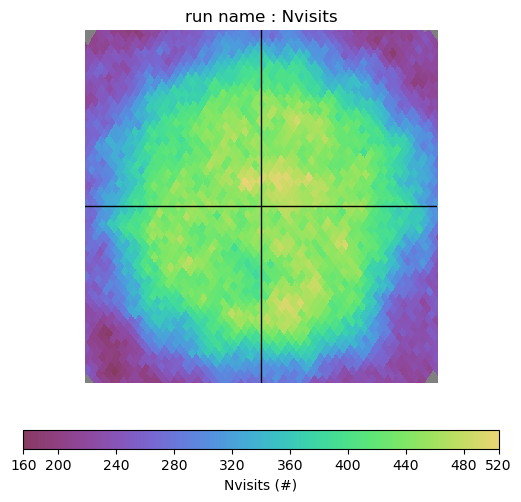

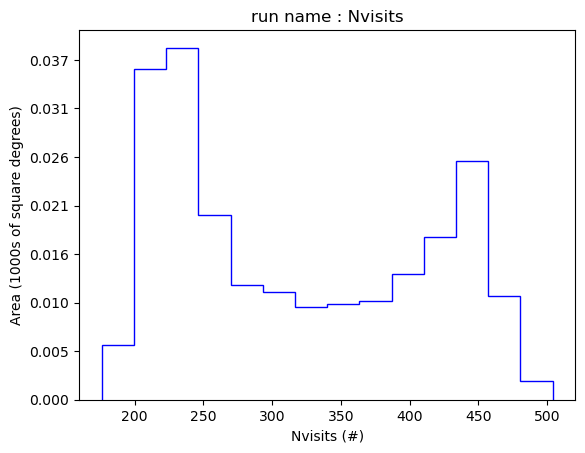

In [401]:
m = metrics.CountMetric('observationStartMJD', metric_name='Nvisits')
hpixnside= 256
s, plot_dict = slicers.make_circle_subset_slicer(dd_ra, dd_dec, radius=radius*1.5, nside=hpixnside, use_cache=False)
constraint = ''
bundle = mb.MetricBundle(m, s, constraint, plot_dict=plot_dict)
g = mb.MetricBundleGroup({0: bundle}, None)
g.run_current(constraint, sim_data=visitsdf.to_records())

print("Area with more than 800 visits", len(np.where(bundle.metric_values.compressed() > 800)[0]) * hp.nside2pixarea(hpixnside, degrees=True))
print("Area with more than 400 visits", len(np.where(bundle.metric_values.compressed() > 400)[0]) * hp.nside2pixarea(hpixnside, degrees=True))
bundle.plot()

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
u max nvisits 43.0 ratio 0.671875
g max nvisits 83.0 ratio 1.1216216216216217
r max nvisits 116.0 ratio 0.6304347826086957
i max nvisits 121.0 ratio 0.657608695652174
z max nvisits 126.0 ratio 0.7590361445783133
y max nvisits 74.0 ratio 0.4457831325301205


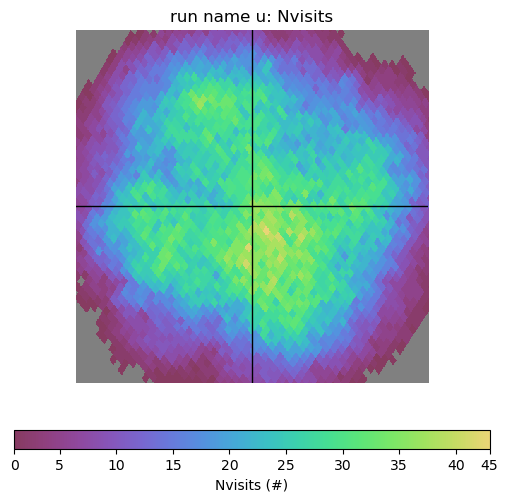

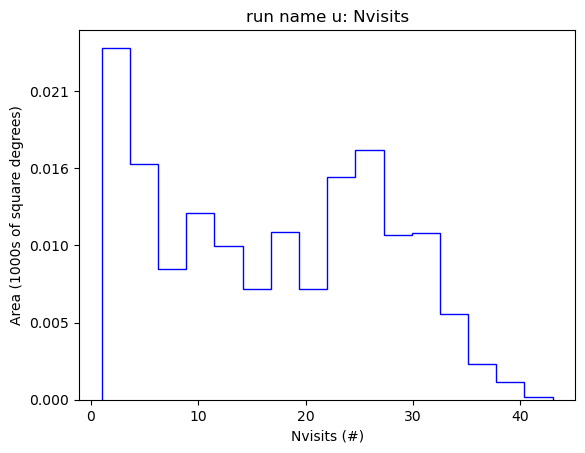

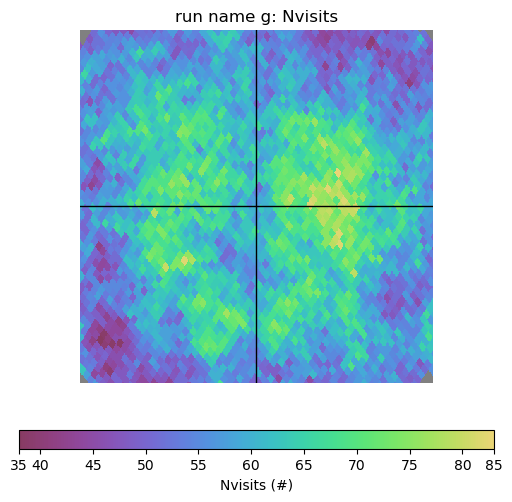

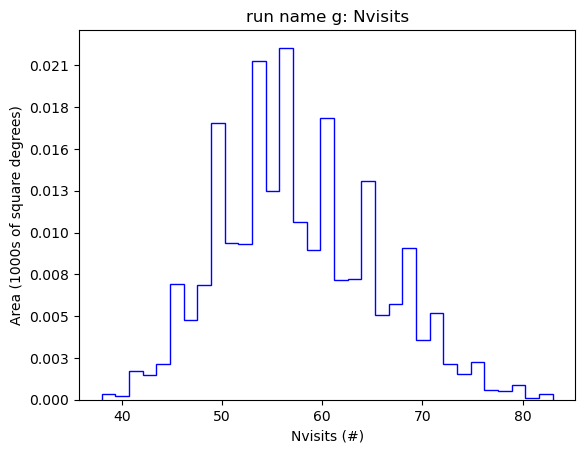

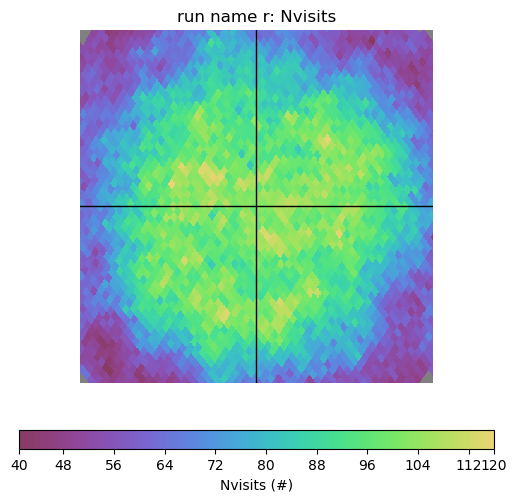

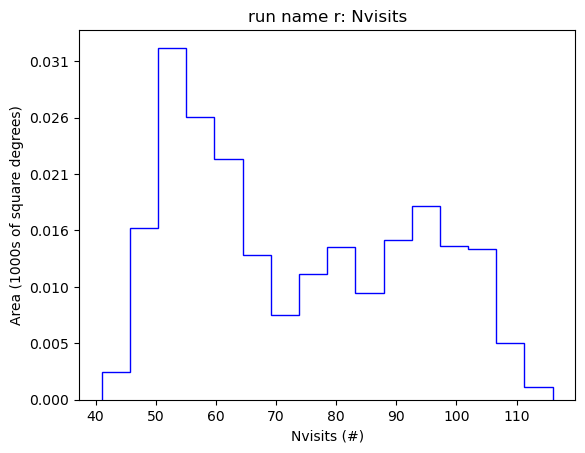

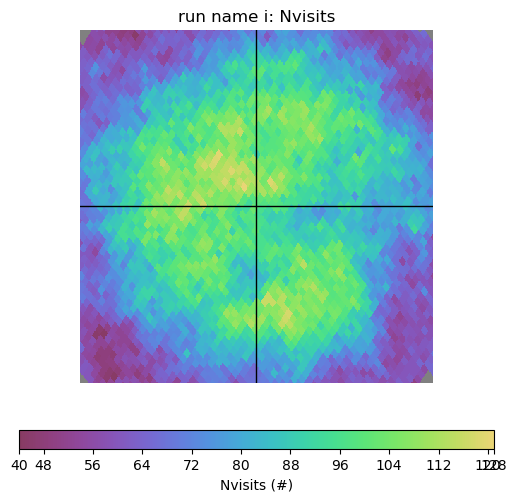

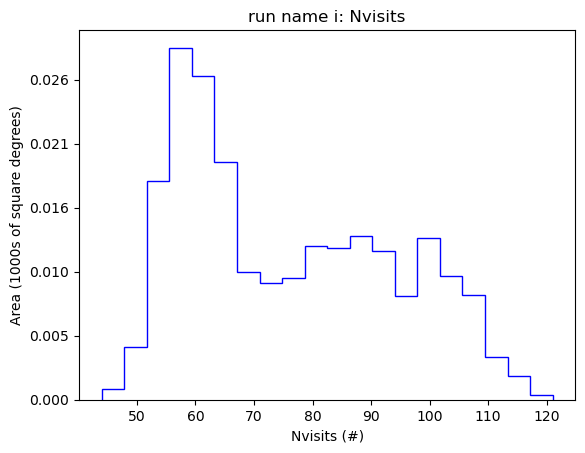

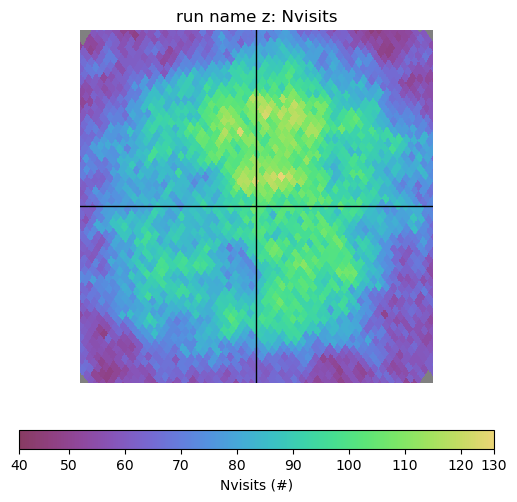

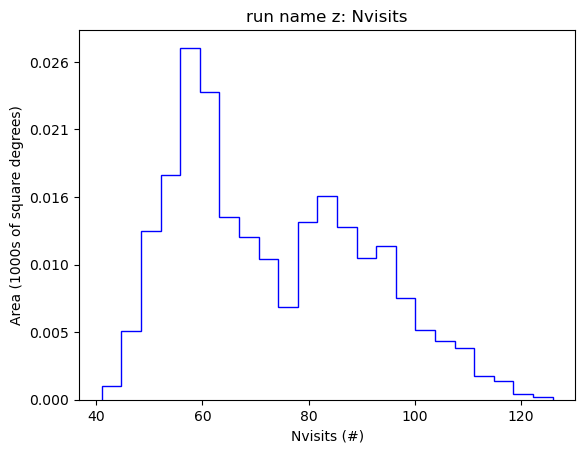

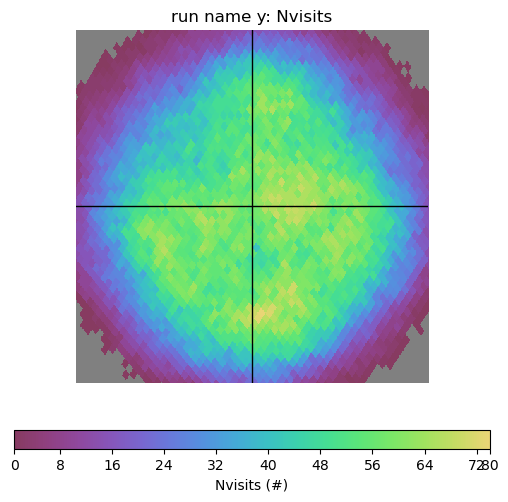

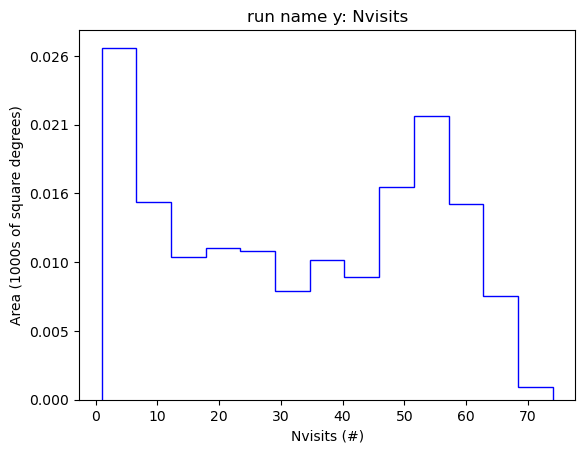

In [378]:
bundles = {}
m = metrics.CountMetric('observationStartMJD', metric_name='Nvisits')
hpixnside= 256
s, plot_dict = slicers.make_circle_subset_slicer(dd_ra, dd_dec, radius=radius*1.5, nside=hpixnside, use_cache=False)
for i, b in enumerate('ugrizy'):
    constraint = b
    bundles[b] = mb.MetricBundle(m, s, constraint, plot_dict=plot_dict)
    g = mb.MetricBundleGroup({0: bundles[b]}, None)
    g.run_current(constraint, sim_data=visitsdf.query("band.str.contains(@b)").to_records())
    print(b, 'max nvisits', bundles[b].metric_values.compressed().max(), 'ratio', bundles[b].metric_values.compressed().max()/dd_goals[i])
    bundles[b].plot()

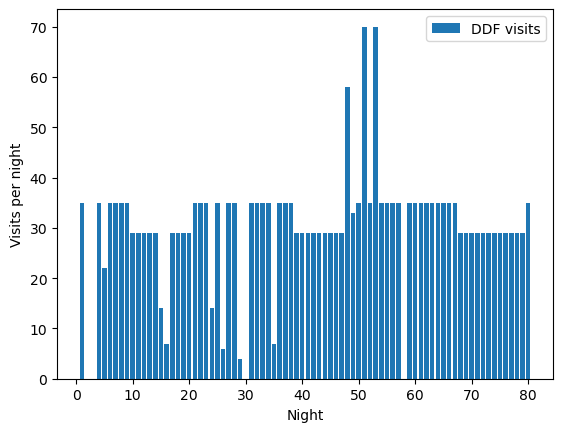

In [403]:
nights = visitsdf.query('target_name.str.contains("DD")').groupby('night').count()['observationStartMJD']
plt.bar(nights.index.values, nights.values, label='DDF visits')
plt.xlabel("Night")
plt.ylabel("Visits per night")
plt.legend()

(0.0, 1.0)

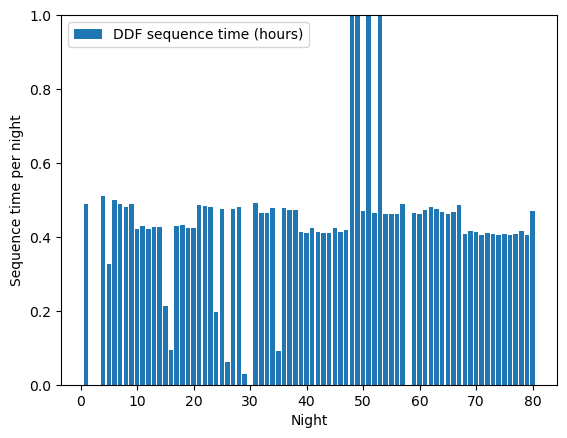

In [410]:
nights = visitsdf.query('target_name.str.contains("DD")').groupby('night').agg({'observationStartMJD': np.ptp})
plt.bar(nights.index.values, nights.observationStartMJD * 24, label='DDF sequence time (hours)')
plt.xlabel("Night")
plt.ylabel("Sequence time per night")
plt.legend()
plt.ylim(0, 1)